# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [6]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title
        
        url = data[0]["url"]  # URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}): continue  # Blacklist (Bob Dylan's case)

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100: continue  # Filter max
        if len(entities) <= 1: continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—": continue  # Remove listings
            if name.startswith("geonames_"): continue  # Skip geotag
            if "readability" in name: continue  # Clean
            if "cliff_clavin_" in name: continue  # Clean
            if "nyt_labeller" in name: continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "): name = name[3:]  # Remove prefix
                if name.endswith(" Corp"): name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"): name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"): name = name[:-4]  # Remive postfix
                if name[0].islower(): continue  # Remove lowercase
                if name[1].isupper(): continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name: continue  # Clean
                if name[1].isupper(): continue  # Remove uppercase
                if name[0].islower(): continue  # Remove lowercase
                if len(name.split(" ")) == 1: continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only

    except:
        continue  # In case of error



articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('The number of articles is ' + str(articles.shape[0]))

articles.sample(1)


The number of articles is 18153


,year,title,url,subjects,orgs,people
17081,2019,APM’s industrialisation challenge,https://mwnation.com/apms-industrialisation-ch...,"[economic conditions and trends, finances, lab...",[Economics Association of Malawi],[Peter Mutharika]


## Entities

In [23]:
entities = np.empty((0, 12), dtype=object)

years_template = { 2011:0, 2012:0, 2013:0, 2014:0, 2015:0, 2016:0, 2017:0, 2018:0, 2019:0, 2020:0 }

def update(type): # Function for writing

    global entity
    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        None,
                        None,
                        None,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows(): # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update("subject")

    for entity in row["orgs"]:
        update("org")
      
    for entity in row["people"]:
        update("person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype({
    "a": int, "b": complex, "c" : float, "d" : int
})


print('The total number of entities is', len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 68338


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Ramachandra University, Aishwarya Sudhir, Min..."


# Treatment

## Frequency Scale

In [39]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
frequency_scaled
# df = pd.DataFrame(x_scaled)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1161,Supreme Court,org,343,5.133152,#b40426,268,373,p_4,"{2011: 1, 2012: 9, 2013: 16, 2014: 15, 2015: 3...",[https://www.newslaundry.com/shorts/prakash-ja...,[Prakash Javadekar was to help tackle Delhi’s ...,"[Amarinder Singh, Manisha Sisodia of Delhi, Co...",0.041176


## Entity Filter

In [131]:
n = 100 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
365,gas (fuel),subject,288,-20.509697,#CCCCCC,521,499,-1,"{2011: 12, 2012: 13, 2013: 22, 2014: 31, 2015:...",[https://www.prnewswire.co.uk:443/news-release...,[International Gas Union welcomes findings of ...,"[International Gas Union Global Gas, electric ...",0.033824


## Linear Regression

In [132]:
# For each

for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities['type'] == 'subject']
average_subjects = entities_subjects['slope'].mean()
for i, row in entities_subjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities['type'] != 'subject']
average_nosubjects = entities_nosubjects['slope'].mean()
for i, row in entities_nosubjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
33,electric light and power,subject,5293,54.902424,#CCCCCC,584,478,-1,"{2011: 170, 2012: 117, 2013: 373, 2014: 526, 2...",[http://www.tampabay.com/news/business/energy/...,[Debate over energy legislation comes down to ...,"[Florida Power & Light, Duke University, Charl...",0.702941


## Colors

In [133]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    
    if row['type'] != 'subject':
        entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope']))) # Actors
    else:
        entities.at[i, 'color'] = '#CCCCCC' # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,135.047879,#CCCCCC,373,731,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Ramachandra University, Aishwarya Sudhir, Min...",1.0


# Embedding

## Term Frequency

In [134]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Ramachandra University', 50037),
 ('Aishwarya Sudhir', 1295),
 ('Ministry of Science and Technology', 40941),
 ('Bhure Lal', 6908),
 ('Karan Madan', 32546)]

## UMAP

In [135]:

reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix) # Reducer
embedding = align_points_to_grid(embedding) # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900)) # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0 # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1749,ExxonMobil,org,86,-1.539576,#3b4cc0,878,563,n_1,"{2011: 1, 2012: 3, 2013: 6, 2014: 8, 2015: 5, ...",[http://grist.org/climate-energy/how-you-can-h...,[How you can help clean energy eat Big Oil&#82...,"[Community Power Network, Unity College, Ameri...",0.006818


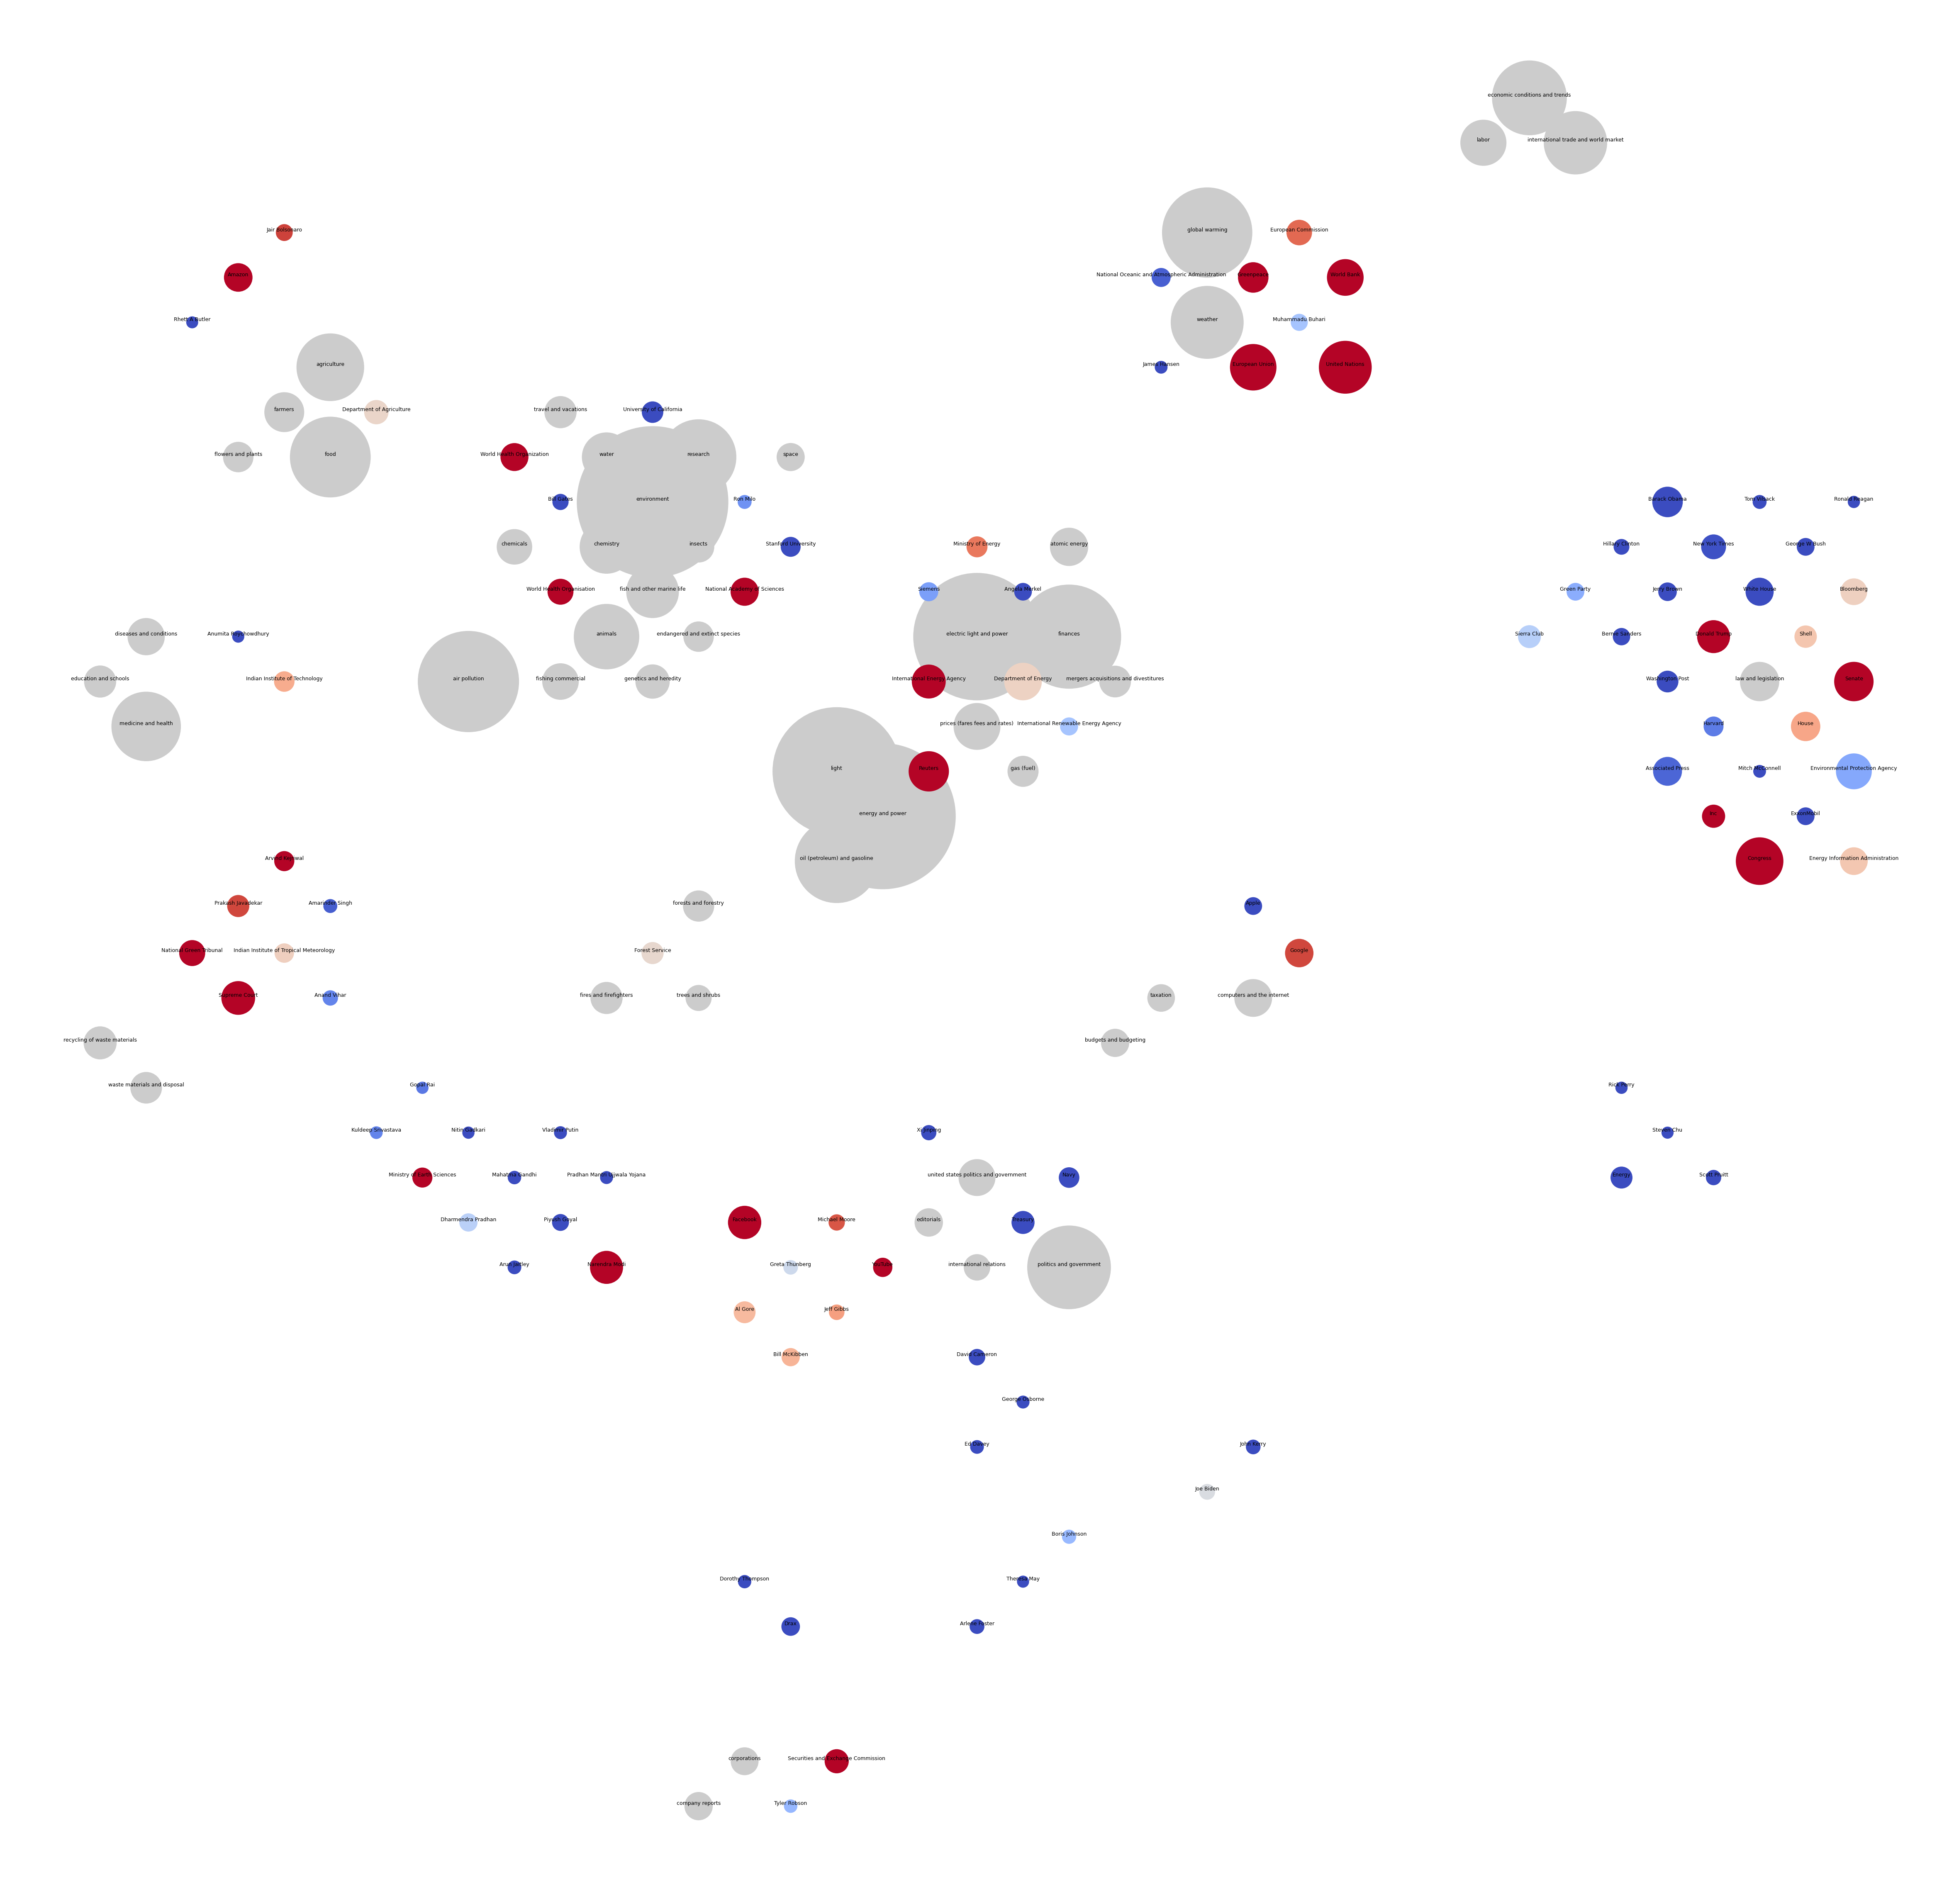

In [136]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")

## Clustering

In [137]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=1,  
    min_cluster_size=3, # 2 — which means 3 elements — is the smallest cluster size
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities['cluster'] = '-1' # Reset

def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_
    
    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, 'cluster'] = prefix + str(clusters[count])
        else:
            entities.loc[index, 'cluster'] = str(clusters[count])
    
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)], 'p_', entities)
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)], 'n_', entities)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
365,gas (fuel),subject,288,-20.509697,#CCCCCC,521,584,-1,"{2011: 12, 2012: 13, 2013: 22, 2014: 31, 2015:...",[https://www.prnewswire.co.uk:443/news-release...,[International Gas Union welcomes findings of ...,"[International Gas Union Global Gas, electric ...",0.033824


{'p_2', 'p_1', 'p_4', 'n_0', 'n_2', 'n_3', 'n_1', 'n_4', 'p_3', 'p_0'}


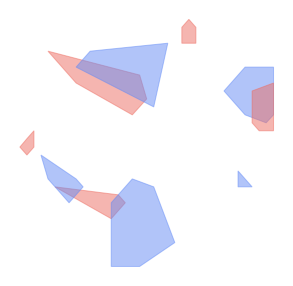

In [138]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())
clusters.remove("-1")  # Remove -1

print(clusters)

for counter, cluster in enumerate(clusters):

    rows = entities.loc[entities["cluster"] == cluster]  # Rows
    points = []  # Points
    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)
    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    if cluster[0] == 'p':
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    else:
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [139]:
entities.to_csv("src/data/entities.csv", index=False)